# PROJET NUMERIQUE : LIGNES DE NIVEAU  

Corentin Hennion, Léa Mailhol

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import autograd

Les fonctions qui nous serviront pour vérifier notre programme : 

In [2]:
def f(x,y):
    return np.exp(-x**2-y**2)

def g(x,y):
    return np.exp(-(x-1)**2-(y-1)**2)

def h(x,y):
    return 2*(f(x,y)-g(x,y))

# AMORCE

On implemente la fonction find_seed. C'est une dichotomie sur un intervalle [inf,sup]. Pour être certain qu'il existe c tel que dans [inf,sup] tel que f(0,t)=c, il faut que (f(0,inf)-c)(f(0,sup)-c) soit négatif. 

In [3]:
def find_seed(g,inf,sup,c=0,eps=2**(-26)):
    if (g(inf)-c)*(g(sup)-c)>0:     #teste la présence d'un zéro de la fonction (en la considérant monotone car sur un petit
        return None                 #intervalle)
    else:
        deb=inf
        fin=sup
        m=(deb+fin)/2
        if g(inf)>=g(sup):
            dec=True                #la fonction est décroissante
        else :
            dec=False               #la fonction est croissante
        while np.abs((g(m)-c))>eps: #algorithme de dichotomie classique
            if g(m)>c:
                if dec:
                    deb=m
                else:
                    fin=m
            elif g(m)<c:
                if dec:
                    fin=m
                else:
                    deb=m
            m=(deb+fin)/2
        return m

In [4]:
def newton(point_init,centre_cercle,f,c,delta,eps=2**(-26)): #point init est le point trouvé sur la tangente, centre cercle est
    def F(x,y):                                              #le point précédent
        return(np.array([f(x,y)-c,(x-centre_cercle[0])**2+(y-centre_cercle[1])**2-delta**2])) #fonction qui annule f sur le 
    point=point_init                                                                          #contour à distance delta du
    valeur_F=F(point_init[0],point_init[1])                                                   #point précédent grâce au cercle
    while np.abs(valeur_F[0])>eps or np.abs(valeur_F[1])>eps: #méthode de Newton en dimension 2 avec la jacobienne
        J=np.c_[autograd.jacobian(F,0)(point[0],point[1]),autograd.jacobian(F,1)(point[0],point[1])]
        J_inv=np.linalg.inv(J)
        point=point-np.dot(J_inv,F(point[0],point[1]))
        valeur_F=F(point[0],point[1])
    return point                 #nouveau point du contour à distance delta du précédent

# PROPAGATION

Pour la fonction simple_contour, on commence par se placer sur une arête du carré. On trouve le point de départ(celui qui appartient à l'arête et à la ligne de niveau) grâce à find_seed puis on se déplace d'un pas delta sur la tangente à la ligne de niveau. 

Pour trouver la tangente à la ligne de niveau nous calculons le gradient de f au point (x,y). Nous avons donc un vecteur orthogonal au vecteur directeur de la tangente.
Pour se rapprocher de la valeur exacte, tout en restant à une distance delta de l'ancien point, nous réalisons une méthode de Newton à F qui vérifie f(x,y)=c et qui appartient au cercle de rayon delta.

# ZZZ

Il y a un bug dans `simple_contour` : lorsque vous choisissez le vecteur tangent à la courbe pour définir le point d'initialisation de la méthode de Newton, il y a deux solutions opposées. Le choix de la solution dépend du tout premier point et de la convention à respecter pour rester dans le carré (pour les autres points, il faut alors garder la même convention). Vous avez choisi une convention par défaut qui fait que vous avez une chance sur deux de partir du mauvais côté et de vous arrêter (cf. test proposé juste en dessous).

En pratique, cela affecte peu votre résulat final car il semble que les lignes que vous ratez sur une arête sont retrouvées sur une des autres arêtes. C'est indolore sur la fonction de test mais je ne suis pas convaincu que cela fonctionne en toute circonstance...

In [5]:
def simple_contour(f,absinf,abssup,ordinf,ordsup,arete,c=0,delta=0.01,eps=2**(-26)): #abssup, absinf, ordsup,ordinf délimitent le carré
    if arete=="gauche":  #permet de se placer sur une des quatre arête pour faire une dichtomie et trouve un point d'initialisation
        x=[absinf]      
        def g(t):
            return f(absinf,t)
        y=[find_seed(g,ordinf,ordsup,c)]
        i=0
        if y==[None]:
            return [],[]
    elif arete=='droite':
        x=[abssup]
        def g(t):
            return f(abssup,t)
        y=[find_seed(g,ordinf,ordsup,c)]
        i=0
        if y==[None]:
            return [],[]
    elif arete=='haut':
        def g(t):
            return f(t,ordsup)
        x=[find_seed(g,absinf,abssup,c)]
        y=[ordsup]
        i=0
        if x==[None]:
            return [],[]
    elif arete=='bas':
        def g(t):
            return f(t,ordinf)
        x=[find_seed(g,absinf,abssup,c)]
        y=[ordinf]
        i=0
        if x==[None]:
            return [],[]
    while x[i]>=absinf and x[i]<=abssup and y[i]>=ordinf and y[i]<=ordsup:
        grad=np.array([autograd.grad(f,0)(x[i],y[i]),autograd.grad(f,1)(x[i],y[i])])
        ortho=np.array([-grad[1],grad[0]])
        orthonorm=ortho/(np.sqrt(ortho[0]**2+ortho[1]**2)) #vecteur unitaire dirigeant la tangente
        point_init=np.array([x[i],y[i]])+delta*orthonorm  #on avance d'une distance delta sur la tangente au contour
        new=newton(point_init,(x[i],y[i]),f,c,delta,eps)  #recherche du nouveau point du contour avec newton
        x.append(new[0])
        y.append(new[1])
        i+=1
    return x,y

# ZZZ 
Illustration du bug : dans la cellule suivante, une seule ligne de niveau est correctement tracée. Celle pour `circ1` s'arrête instantanément.

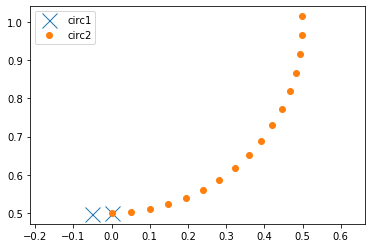

In [6]:
def circ1(x,y):
    return x**2+y**2

def circ2(x,y):
    return x**2+(y-1)**2

(x1,y1)=simple_contour(circ1,0.,1.,0.,1.,"gauche",c=0.25,delta=0.05)
(x2,y2)=simple_contour(circ2,0.,1.,0.,1.,"gauche",c=0.25,delta=0.05)

plt.plot(x1,y1,'x',markersize=15)
plt.plot(x2,y2,'o')
plt.legend(["circ1","circ2"])
plt.axis("equal")
plt.show()

# CONTOUR COMPLEXE

Enfin, la fonction contour rassemble les données de tous les carrés et des quatre fonctions simple_contour

In [7]:

def contour(f,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],delta=0.01): #yc et xc représentent le quadrillage de la zone considérée
    xs=[]
    ys=[]
    for i in range(len(xc)-1):  #crée tous les contours présents dans chaque case du quadrillage
        for j in range(len(yc)-1):
            a,b=simple_contour(f,xc[i],xc[i+1],yc[j],yc[j+1],"gauche",c,delta)
            xs.append(a)
            ys.append(b)
            a,b=simple_contour(f,xc[i],xc[i+1],yc[j],yc[j+1],"droite",c,delta)
            xs.append(a)
            ys.append(b)
            a,b=simple_contour(f,xc[i],xc[i+1],yc[j],yc[j+1],"haut",c,delta)
            xs.append(a)
            ys.append(b)
            a,b=simple_contour(f,xc[i],xc[i+1],yc[j],yc[j+1],"bas",c,delta)
            xs.append(a)
            ys.append(b)
    return xs,ys

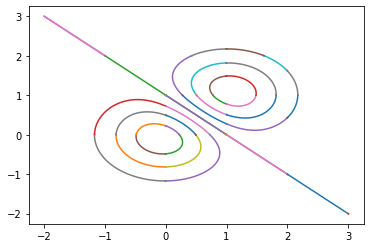

In [8]:
def tracer(h):
    for c in [-1.5,-1,-0.5,0,0.5,1,1.5]:
        xs, ys=contour(h,c,[-2.,0.,1.,2.,3.],[-2.,0.,1.,2.,3.])
        for x,y in zip(xs,ys):
            plt.plot(x,y)
    plt.show()
    
tracer(h)